In [91]:
import pandas as pd
import os
from datetime import datetime
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
df = pd.read_csv("Datasets\CarRegistrations.csv",header=None, index_col=[0],parse_dates=[0])

In [93]:
df.index = df.index.str.replace("M","-")

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 325 entries, 1995-01 to 2022-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1       325 non-null    int64
dtypes: int64(1)
memory usage: 5.1+ KB


In [95]:
df.head()

,1
0,
1995-01,10817
1995-02,8916
1995-03,9697
1995-04,10314
1995-05,9775


In [96]:
df.tail()

,1
0,
2021-09,6354
2021-10,3882
2021-11,2167
2021-12,832
2022-01,15814


In [97]:
df.size

325

In [98]:
df.describe()

,1
count,325.000000
mean,10510.541538
std,7175.563409
min,474.000000
25%,4355.000000
50%,9359.000000
75%,15384.000000
max,32961.000000


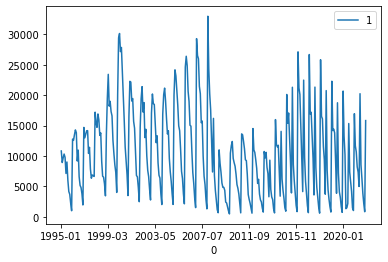

In [99]:
df.plot()

In [100]:
# this plot shows that there is a variation in the data. This violates the assumption of stationary data
# To identify whther the data is stationary in a more clear manner, we will apply a factor called smoothing the series.
# Smoothing means, we will calculate moving average for specific intervals

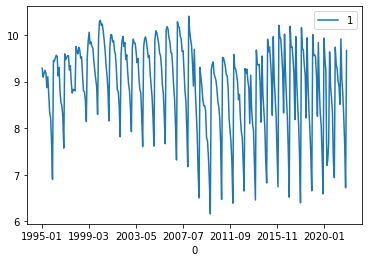

In [103]:
df_transformed_log = df.transform(np.log)
df_transformed_log.plot()

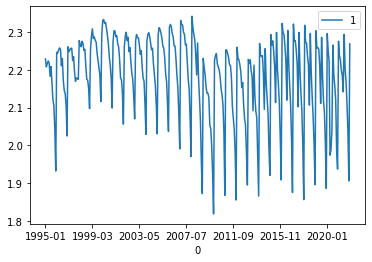

In [109]:
df_transformed_log_2 = df_transformed_log.transform(np.log)
df_transformed_log_2.plot()

In [106]:
# df.shape
df_transformed_log.shape

(325, 1)

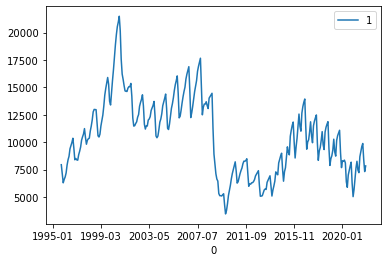

In [107]:
df_mean = df.rolling(window=10).mean()
df_mean.plot()

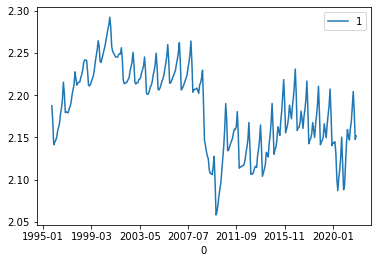

In [110]:
df_log_mean = df_transformed_log_2.rolling(window=10).mean()
df_log_mean.plot()

In [111]:
df_mean.shape

(325, 1)

In [48]:
# this plot clearly indicates that there are trends in the series. 

In [49]:
# Creating a baseline model. So that we can get the basic idea of errors in the prediction.
# Assmption : The expected value of a precord is the previous value of that record. 
# Recent history is the best reflection of the future.

In [50]:
# df["Forecasted_registrations"] = df.shift(1)

In [51]:
df.shape

(325, 1)

In [52]:
# df.columns

In [112]:
# df_baseline = pd.concat([df,df.shift(1)],axis=1)
df_baseline_log = pd.concat([df_transformed_log,df_transformed_log.shift(1)],axis=1)

In [113]:
df_baseline_log.tail()

,1,1
0,,
2021-09,8.756840,9.055206
2021-10,8.264106,8.756840
2021-11,7.681099,8.264106
2021-12,6.723832,7.681099
2022-01,9.668651,6.723832


In [114]:
# df_baseline.columns = ["Actual_registrations","Forecased_registrations"]
df_baseline_log.columns = ["Actual_registrations","Forecased_registrations"]

In [115]:
df_baseline_log = df_baseline_log[1:]

In [117]:
df_baseline_log.head()

,Actual_registrations,Forecased_registrations
0,,
1995-02,9.095603,9.288874
1995-03,9.179572,9.095603
1995-04,9.241257,9.179572
1995-05,9.187583,9.241257
1995-06,8.871365,9.187583


In [118]:
df_baseline_log.shape

(324, 2)

In [119]:
df_baseline_log.describe()

,Actual_registrations,Forecased_registrations
count,324.000000,324.000000
mean,8.933799,8.932627
std,0.926585,0.925893
min,6.161207,6.161207
25%,8.369364,8.369364
50%,9.141254,9.141254
75%,9.642396,9.640156
max,10.403080,10.403080


In [120]:
# baseline_error = mean_squared_error(df_baseline.Actual_registrations,df_baseline.Forecased_registrations)
# baseline_error
baseline_error_log = mean_squared_error(df_baseline_log.Actual_registrations,df_baseline_log.Forecased_registrations)
baseline_error_log

0.8651446658278386

In [122]:
np.sqrt(baseline_error_log)

0.9301315314662968

In [61]:
# as we can see that, error this error for our baseline model is too high.

In [125]:
df_baseline_log.shape

(324, 2)

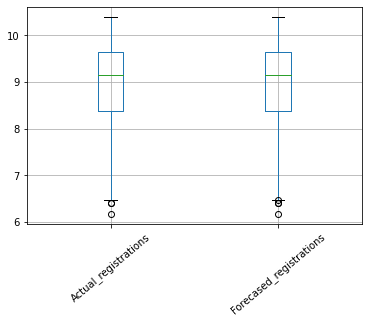

In [126]:
box_plot = df_baseline_log.boxplot(rot=40)
box_plot

In [129]:
min_threshold, max_threshold = df_baseline_log.Actual_registrations.quantile([0.05,0.95])

In [130]:
max_threshold

10.077607679160783

In [131]:
# df_filtered = df_baseline[df_baseline.Actual_registrations.between(*df_baseline.Actual_registrations.quantile([0.05,0.95]))]
# df_baseline_filtered = df_baseline[df_baseline["Actual_registrations"] < max_threshold]
df_baseline_filtered = df_baseline_log[(df_baseline_log["Actual_registrations"] > min_threshold) & (df_baseline_log["Actual_registrations"] < max_threshold)]

In [132]:
df_baseline_filtered.describe()

,Actual_registrations,Forecased_registrations
count,290.000000,290.000000
mean,8.994363,9.015681
std,0.740935,0.815178
min,7.173192,6.161207
25%,8.480321,8.576075
50%,9.141254,9.173151
75%,9.595603,9.617367
max,10.060961,10.207510


In [133]:
df_baseline_filtered.shape

(290, 2)

In [134]:
# We have used quantile method to describe minimum and maximum threshold.
# After some trial and errors, we have defined minimum and maximum thresholds as 5 %  and 95 % of the data. 
# We have defined such threshold because, as we have limited records, (324), 
# we do not want to filter lot of the data not to overfit our model.
# Outliers are defined as data points beyond 3rd quartile + IQR * (1.5) and 1st Quartile - IQR * (1.5)
# IQR is interquartile range

# Also, as the box plot represents, one particular data point in "Actual_registrations" is an outlier, 
# which is the maximum value in the dataset (32961)
# We will remove the outlier and test the basline model error.

In [135]:
filtered_error = mean_squared_error(df_baseline_filtered.Actual_registrations, df_baseline_filtered.Forecased_registrations)
np.sqrt(filtered_error)

0.8399413179043634

In [136]:
df_baseline_filtered.shape

(290, 2)

In [75]:
# By removing an extreme outlier in the data, we have reduced the mean square error from from 0.93 to 0.83.
# This means that, in the naive model, we can expect the prediction error is plus or minus 0.83.
# This reflects that, whatever advance module we are going to produce,
# The model will always have the error which is below this error. 
# By filtering the model, the size of the data set also has reduced to 307

#### ARIMA AutoRegressiove Integrated Moving Average (p,d,q)

ARIMA   has basically 3 components

In [85]:
# 3 components: Auto regresive:The Previous value is the best reflection of the current value (p)
# Integrated: Order of difference: (d) To make the time series stationary
# Moving average. Smoothness by removing noise from the data (q)

Autoregressive : We are going to check the relation a between the previous values and the next values

If the correlation  is present in any consicutive records, we will not take those records.

Because, we the correlation hampers the performance of the model.

In [86]:
# The packages we are going to use for this are "plot_act" and "plot_pacf"
# plot_acf is used to identify the parameter Q
#

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

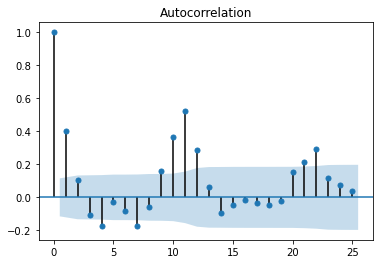

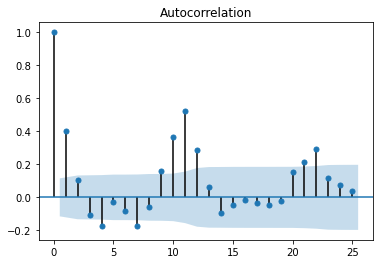

In [138]:
plot_acf(df_baseline_filtered.Actual_registrations) # to identify the value of q

In [ ]:
# As we can see that,correlatio is present at level 1 and level 2.
# 3rd level is under critical limit
# Hence, we can experiment with the q vale of 3 and 4.

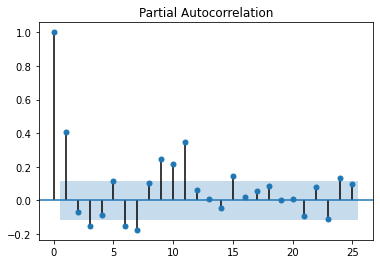

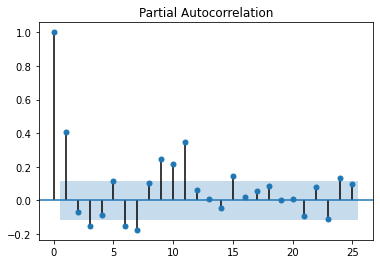

In [139]:
plot_pacf(df_baseline_filtered.Actual_registrations) # to identify the value of p

In [140]:
# here also 1st level and 2nd is out of critical limit. 
# So here also, we can experiment with 3rd and 4th level to identify the value of p

also, as we could see the trends in the plot violating the assumptions of standard data, we will experiment the value of d 

In [142]:
# p = 3 or 4 , d = 1 ,q = 3 or 4
df_baseline_filtered.shape

(290, 2)

In [145]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_baseline_filtered.Actual_registrations,test_size=0.2)

In [148]:
print(df_test.shape)
print(df_train.shape)

(58,)
(232,)


In [156]:
from statsmodels.tsa.arima_model import ARIMA

In [183]:
ARIMA_model = ARIMA(df_train,order = (2,1,3))

C:\Users\NIKIL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\NIKIL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [184]:
ARIMA_fit  = ARIMA_model.fit()

In [185]:
ARIMA_fit.aic

515.931224335062

In [187]:
df_forecast = ARIMA_fit.forecast(steps = 58)[0]
df_forecast

array([9.22933277, 8.94024067, 9.02568607, 9.1538351 , 8.85658507,
       9.24009982, 8.87073603, 9.13578267, 9.03518297, 8.95635946,
       9.18526687, 8.87207154, 9.18764247, 8.94846687, 9.05689604,
       9.09904078, 8.92589734, 9.18012532, 8.91291498, 9.12667939,
       9.01671402, 9.00210056, 9.13100503, 8.926785  , 9.15190982,
       8.96331806, 9.07126186, 9.0665515 , 8.97328093, 9.13629445,
       8.94840071, 9.11370439, 9.01111601, 9.02967581, 9.09540127,
       8.96699683, 9.12317002, 8.97998545, 9.07595826, 9.04873919,
       9.00490221, 9.10534559, 8.97690928, 9.10041314, 9.01263033,
       9.04549434, 9.0730204 , 8.99587826, 9.10117106, 8.99590716,
       9.07556494, 9.04025635, 9.02550814, 9.08427331, 8.99906041,
       9.08858805, 9.01765183, 9.05398657])

In [189]:
mean_sqr_error = mean_squared_error(df_test,df_forecast)
np.sqrt(mean_sqr_error)

0.7700852594513303